## Goal

This is Kaggle Challenge - In a world... where movies made an estimated $41.7 billion in 2018, the film industry is more popular than ever. But what movies make the most money at the box office? How much does a director matter? Or the budget? For some movies, it's "You had me at 'Hello.'" For others, the trailer falls short of expectations and you think "What we have here is a failure to communicate."

In this competition, you're presented with metadata on over 7,000 past films from The Movie Database to try and predict their overall worldwide box office revenue. Data points provided include cast, crew, plot keywords, budget, posters, release dates, languages, production companies, and countries

It is your job to predict the international box office revenue for each movie. For each id in the test set, you must predict the value of the revenue variable. 

Submissions are evaluated on Root-Mean-Squared-Logarithmic-Error (RMSLE) between the predicted value and the actual revenue. Logs are taken to not overweight blockbuster revenue movies.

Submission File Format
The file should contain a header and have the following format:

id,revenue
1461,1000000
1462,50000
1463,800000000
etc.

## Data Description

In this dataset, you are provided with 7398 movies and a variety of metadata obtained from The Movie Database (TMDB). Movies are labeled with id. Data points include cast, crew, plot keywords, budget, posters, release dates, languages, production companies, and countries.

You are predicting the worldwide revenue for 4398 movies in the test file.

Note - many movies are remade over the years, therefore it may seem like multiple instance of a movie may appear in the data, however they are different and should be considered separate movies. In addition, some movies may share a title, but be entirely unrelated.

E.g. The Karate Kid (id: 5266) was released in 1986, while a clearly (or maybe just subjectively) inferior remake (id: 1987) was released in 2010. Also, while the Frozen (id: 5295) released by Disney in 2013 may be the household name, don't forget about the less-popular Frozen (id: 139) released three years earlier about skiers who are stranded on a chairlift...

This is my first Kaggle kernel.So very excited and looking forward to feedback from kaggle community.

In [22]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import ast
from collections import Counter

In [2]:
# Data import
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

## Exploratory Data Analysis

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
id                       3000 non-null int64
belongs_to_collection    604 non-null object
budget                   3000 non-null int64
genres                   2993 non-null object
homepage                 946 non-null object
imdb_id                  3000 non-null object
original_language        3000 non-null object
original_title           3000 non-null object
overview                 2992 non-null object
popularity               3000 non-null float64
poster_path              2999 non-null object
production_companies     2844 non-null object
production_countries     2945 non-null object
release_date             3000 non-null object
runtime                  2998 non-null float64
spoken_languages         2980 non-null object
status                   3000 non-null object
tagline                  2403 non-null object
title                    3000 non-null object
Keywords             

In [4]:
train.head(3)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000


Let's summarize meaning of each column

In [5]:
'''Total rows:3000
Data columns (total 23 columns):
id                       3000 non-null int64   unique id given to movie
belongs_to_collection    604 non-null object   title,poster path etc given in jason format
budget                   3000 non-null int64   budget of the movie,assuming in USD
genres                   2993 non-null object  one movie can have multiple genre given in list of dictionaries
homepage                 946 non-null object   homepage of production company,I think
imdb_id                  3000 non-null object  unique id given to movie on IMDB website
original_language        3000 non-null object  original_language of the movie
original_title           3000 non-null object  title of the movie
overview                 2992 non-null object  short overview about movie story
popularity               3000 non-null float64 Some score based on popularity,how this score is calculated is not provided to us
poster_path              2999 non-null object  path to image of movie poster
production_companies     2844 non-null object  one movie can have multiple production companies given in list of dictionaries
production_countries     2945 non-null object  name of the country where movie production took place given in dictionary format
release_date             3000 non-null object  movie release date in mm/dd/yy format
runtime                  2998 non-null float64 movie runtime in minutes
spoken_languages         2980 non-null object  language spoken in movie given in list of dictionary 
status                   3000 non-null object  Status of the movie.Either 'Released' or 'Rumored'
tagline                  2403 non-null object  Tagline given in String format
title                    3000 non-null object  Title of the movie
Keywords                 2724 non-null object  List of keywords related to movie plot
cast                     2987 non-null object  List of cast and its details
crew                     2984 non-null object  list of crew and their details
revenue                  3000 non-null int64   revenue earned by the movie,this is our taget variable.'''

"Total rows:3000\nData columns (total 23 columns):\nid                       3000 non-null int64   unique id given to movie\nbelongs_to_collection    604 non-null object   title,poster path etc given in jason format\nbudget                   3000 non-null int64   budget of the movie,assuming in USD\ngenres                   2993 non-null object  one movie can have multiple genre given in list of dictionaries\nhomepage                 946 non-null object   homepage of production company,I think\nimdb_id                  3000 non-null object  unique id given to movie on IMDB website\noriginal_language        3000 non-null object  original_language of the movie\noriginal_title           3000 non-null object  title of the movie\noverview                 2992 non-null object  short overview about movie story\npopularity               3000 non-null float64 Some score based on popularity,how this score is calculated is not provided to us\nposter_path              2999 non-null object  path to

In [6]:
#Create dataset for cleaning and exploring
train_explr = train

#### Explore: belongs_to_collection vs revenue

In [7]:
train_explr.belongs_to_collection.describe()

count                                                   604
unique                                                  422
top       [{'id': 645, 'name': 'James Bond Collection', ...
freq                                                     16
Name: belongs_to_collection, dtype: object

In [8]:
train_explr['belongs_to_collection'][0]

"[{'id': 313576, 'name': 'Hot Tub Time Machine Collection', 'poster_path': '/iEhb00TGPucF0b4joM1ieyY026U.jpg', 'backdrop_path': '/noeTVcgpBiD48fDjFVic1Vz7ope.jpg'}]"

title,poster path etc.I don't think this feature with so many empty values will be useful to determine revenue.So let's drop it

In [9]:
train_explr = train_explr.drop(columns=['belongs_to_collection'],axis=1)
test = test.drop(columns=['belongs_to_collection'],axis=1)


#### Explore: budget vs revenue

In [10]:
train_explr.budget.describe()

count    3.000000e+03
mean     2.253133e+07
std      3.702609e+07
min      0.000000e+00
25%      0.000000e+00
50%      8.000000e+06
75%      2.900000e+07
max      3.800000e+08
Name: budget, dtype: float64

(array([2.411e+03, 3.630e+02, 1.230e+02, 5.500e+01, 2.000e+01, 1.700e+01,
        7.000e+00, 3.000e+00, 0.000e+00, 1.000e+00]),
 array([0.00e+00, 3.80e+07, 7.60e+07, 1.14e+08, 1.52e+08, 1.90e+08,
        2.28e+08, 2.66e+08, 3.04e+08, 3.42e+08, 3.80e+08]),
 <a list of 10 Patch objects>)

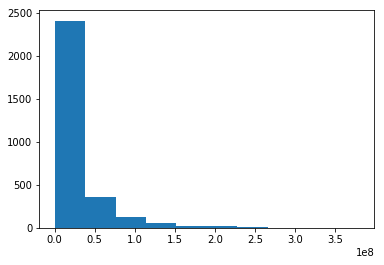

In [11]:
plt.hist(x=train_explr.budget.values)

Budget data is positively skewed,so we'll take log of it

(array([ 822.,    3.,    4.,    2.,    8.,   23.,  126.,  493., 1127.,
         392.]),
 array([ 0.        ,  1.97556818,  3.95113636,  5.92670454,  7.90227273,
         9.87784091, 11.85340909, 13.82897727, 15.80454545, 17.78011363,
        19.75568181]),
 <a list of 10 Patch objects>)

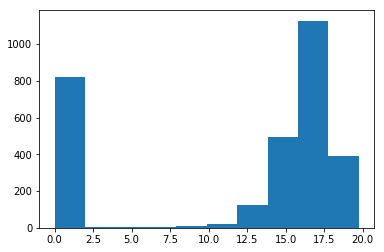

In [12]:
plt.hist(x=np.log1p(train_explr.budget.values))

We can see many values with very less budget,let's confirm with numbers

In [13]:
len(train_explr[train_explr['budget']==0])

812

So we may have to fill these values.Because making movie with 0 budget is not possible.
We will check how to fill these missing values later(After analysing other columns)

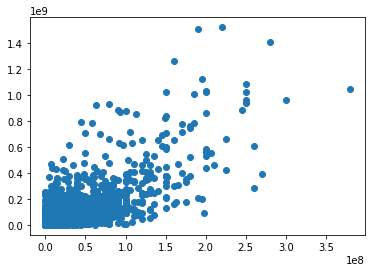

In [15]:
plt.scatter(x=train_explr.budget.values,y=train_explr.revenue.values)

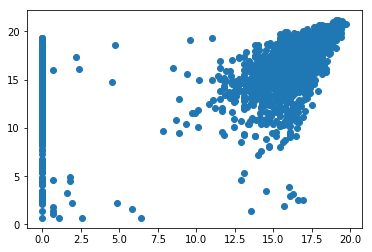

In [16]:
plt.scatter(x=np.log1p(train_explr.budget.values),y=np.log1p(train_explr.revenue.values))

There is linear relationship between budget and revenue.Let's find strenght of correlation 
between these two variables using Pearson
correlation

In [17]:
train_explr.budget.corr(train_explr.revenue,method='pearson')

0.7529645103815281

#### Explore: genre vs revenue

In [18]:
train_explr.genres.describe()

count                              2993
unique                              872
top       [{'id': 18, 'name': 'Drama'}]
freq                                266
Name: genres, dtype: object

In [19]:
train_explr.genres[3]

"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'name': 'Drama'}]"

First we need to convert string to dictionary data

In [24]:
train_explr['genres'] = train_explr.genres.apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x))
test['genres'] = test.genres.apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x))

In [25]:
train_explr.genres.apply(lambda x: len(x) if x != {} else 0).value_counts()

2    972
3    900
1    593
4    393
5    111
6     21
0      7
7      3
Name: genres, dtype: int64

We'll create a feature-Number of genres in a movie and also we'll treat each genre as a feature

In [60]:
train_explr['genres_number'] = train_explr.genres.apply(lambda x:len(x) if x!={} else 0)
test['genres_number'] = test.genres.apply(lambda x:len(x) if x!={} else 0)

TypeError: object of type 'float' has no len()

In [28]:
train_explr.genres_number[:3]

0    1
1    4
2    1
Name: genres_number, dtype: int64

In [48]:
train_explr.genres[0]

[{'id': 35, 'name': 'Comedy'}]

In [49]:
all_genres_list = list(train_explr.genres.apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
all_genres = [c for c in Counter([genre for genres in all_genres_list for genre in genres])]
test_all_genres_list = list(test.genres.apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
test_all_genres = [c for c in Counter([genre for genres in test_all_genres_list for genre in genres])]

In [51]:
all_genres

['Comedy',
 'Drama',
 'Family',
 'Romance',
 'Thriller',
 'Action',
 'Animation',
 'Adventure',
 'Horror',
 'Documentary',
 'Music',
 'Crime',
 'Science Fiction',
 'Mystery',
 'Foreign',
 'Fantasy',
 'War',
 'Western',
 'History',
 'TV Movie']

In [59]:
all_genres_list[1:3]

[['Comedy', 'Drama', 'Family', 'Romance'], ['Drama']]

In [56]:
train_explr['all_genres'] = ""
test['all_genres'] = ""

In [57]:
for i in range(len(all_genres_list)):
    train_explr['all_genres'][i] = all_genres_list[i]
for genre in all_genres:
    train_explr['genre_' + genre] = train_explr['all_genres'].apply(lambda x: 1 if genre in x else 0)

C:\Users\Vani\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [65]:
for i in range(len(all_genres_list)):
    test['all_genres'][i] = test_all_genres_list[i]
for genre in all_genres:
    test['genre_' + genre] = test['all_genres'].apply(lambda x: 1 if genre in x else 0)

C:\Users\Vani\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [ ]:
train_explr = train_explr.drop(columns=['genre','all_genres'],axis=1)
test = test.drop(columns=['genre','all_genres'],axis=1)

I want to create combined feature of budget-genre.But I don't know how to do create feature
by combining continuous and categorical feature.Maybe somebody can help me in comments section

#### Explore: original_language vs revenue

In [113]:
train_explr.original_language.describe()

count     3000
unique      36
top         en
freq      2575
Name: original_language, dtype: object

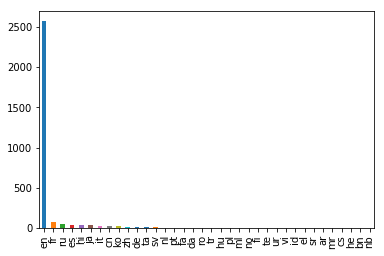

In [121]:
train_explr.original_language.value_counts().plot(kind='bar')

There is data for 36 languages but majority(2500+)movies in English

Let's see average revenue of each language movie

In [135]:
train_explr.groupby(['original_language']).mean()

,id,budget,popularity,runtime,revenue
original_language,,,,,
ar,1332.000000,0.000000e+00,5.451273,98.000000,1.347747e+06
bn,2225.000000,0.000000e+00,3.900709,125.000000,5.363640e+05
cn,1701.800000,6.874077e+06,6.515636,105.450000,2.977289e+07
cs,74.000000,0.000000e+00,0.919556,90.000000,1.739300e+04
da,1430.000000,3.200000e+06,4.819078,105.400000,1.175709e+07
de,1631.888889,4.116763e+06,6.608921,122.294118,2.053090e+07
el,867.000000,1.510000e+05,1.879162,91.000000,8.000000e+06
en,1500.036893,2.534961e+07,9.067088,106.984078,7.466591e+07
es,1440.418605,1.690560e+06,5.507874,100.372093,8.564790e+06


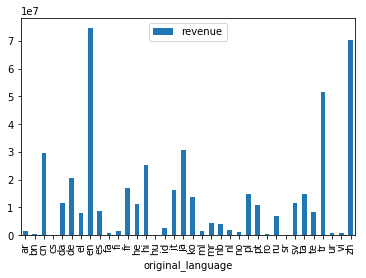

In [140]:
train_explr.groupby(['original_language']).mean()[['revenue']].plot(kind='bar')

English(en),Chinese(zh),Turkish(tr) movies have high revenue per movie compared to other languages

#### Explore:original_title vs revenue

In [141]:
train_explr.original_title.describe()

count                     3000
unique                    2975
top       The Three Musketeers
freq                         2
Name: original_title, dtype: object

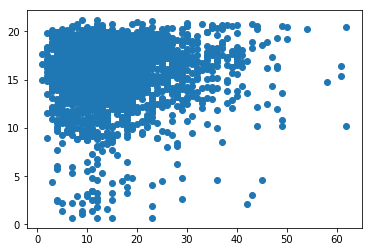

In [150]:
plt.scatter(x=train_explr.original_title.str.len(),y=np.log1p(train_explr.revenue.values))

#### Explore:overview vs revenue

In [152]:
train_explr.overview.describe()

count                                                  2992
unique                                                 2992
top       A student's premonition of a deadly rollercoas...
freq                                                      1
Name: overview, dtype: object

I am not sure how overview of movie would be helpful in deciding revenue

#### Explore:popularity vs revenue

In [154]:
train_explr.popularity.describe()

count    3000.000000
mean        8.463274
std        12.104000
min         0.000001
25%         4.018053
50%         7.374861
75%        10.890983
max       294.337037
Name: popularity, dtype: float64

(array([2.965e+03, 2.300e+01, 2.000e+00, 2.000e+00, 2.000e+00, 1.000e+00,
        2.000e+00, 1.000e+00, 0.000e+00, 2.000e+00]),
 array([1.00000000e-06, 2.94337046e+01, 5.88674082e+01, 8.83011118e+01,
        1.17734815e+02, 1.47168519e+02, 1.76602223e+02, 2.06035926e+02,
        2.35469630e+02, 2.64903333e+02, 2.94337037e+02]),
 <a list of 10 Patch objects>)

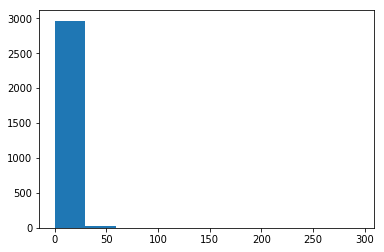

In [155]:
plt.hist(train_explr.popularity)

{'boxes': [<matplotlib.lines.Line2D at 0x2a3a702e2b0>],
 'caps': [<matplotlib.lines.Line2D at 0x2a3a702ecc0>,
 'fliers': [<matplotlib.lines.Line2D at 0x2a3a6f5d978>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x2a3a6f5d550>],
 'whiskers': [<matplotlib.lines.Line2D at 0x2a3a702e400>,
  <matplotlib.lines.Line2D at 0x2a3a702e898>]}

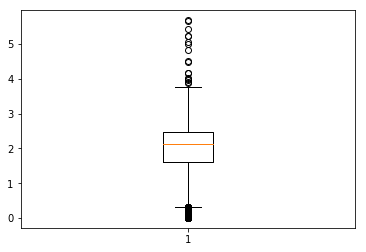

In [161]:
plt.boxplot(np.log1p(train_explr.popularity))

We might need to deal with outliers

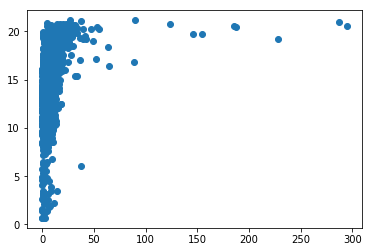

In [158]:
plt.scatter(x=train_explr.popularity,y=np.log1p(train_explr.revenue))

In [159]:
train_explr.popularity.corr(train_explr.revenue)

0.46146028967361286

#### Explore:production_companies vs revenue

In [86]:
train_explr.production_companies.describe()

AttributeError: 'DataFrame' object has no attribute 'production_companies'

In [68]:
train_explr.production_companies[2]

"[{'name': 'Bold Films', 'id': 2266}, {'name': 'Blumhouse Productions', 'id': 3172}, {'name': 'Right of Way Films', 'id': 32157}]"

First we need to convert string to dictionary

In [70]:
train_explr['production_companies'] = train_explr.production_companies.apply(lambda x:{} if pd.isna(x) else ast.literal_eval(x))
test['production_companies'] = test.production_companies.apply(lambda x:{} if pd.isna(x) else ast.literal_eval(x))

In [74]:
train_explr['production_companies_number'] = train_explr.production_companies.apply(lambda x:len(x) if x!={} else 0)
test['production_companies_number'] = test.production_companies.apply(lambda x:len(x) if x!={} else 0)

In [85]:
prod_comp_list = list(train_explr.production_companies.apply(lambda x : [i['name'] for i in x] if x!={} else[]).values)
test_prod_comp_list = list(train_explr.production_companies.apply(lambda x : [i['name'] for i in x] if x!={} else[]).values)
prod_comp = [c for c in Counter([comp for companies in prod_comp_list for comp in companies])]
train_explr['all_prod_comp'] = ""
test['all_prod_comp'] = ""
for i in range(len(prod_comp_list)):
    train_explr['all_prod_comp'][i] = prod_comp_list[i]
for comp in prod_comp:
    train_explr['prod_comp_' + comp] = train_explr['all_prod_comp'].apply(lambda x: 1 if comp in x else 0)
train_explr = train_explr.drop(columns=['production_companies','all_prod_comp'],axis=1)

for i in range(len(prod_comp_list)):
    test['all_prod_comp'][i] = test_prod_comp_list[i]
for comp in prod_comp:
    test['prod_comp_' + comp] = test['all_prod_comp'].apply(lambda x: 1 if comp in x else 0)
test = test.drop(columns=['production_companies','all_prod_comp'],axis=1)


AttributeError: 'DataFrame' object has no attribute 'production_companies'

#### Explore:production_countries vs revenue

In [87]:
train_explr.production_countries.describe()

TypeError: unhashable type: 'list'

In [80]:
train_explr['production_countries'] = train_explr.production_countries.apply(lambda x:{} if pd.isna(x) else ast.literal_eval(x))
test['production_countries'] = test.production_countries.apply(lambda x:{} if pd.isna(x) else ast.literal_eval(x))

In [81]:
train_explr['production_countries_number'] = train_explr.production_countries.apply(lambda x:len(x) if x!={} else 0)
test['production_countries_number'] = test.production_countries.apply(lambda x:len(x) if x!={} else 0)

In [84]:
prod_country_list = list(train_explr.production_countries.apply(lambda x : [i['name'] for i in x] if x!={} else[]).values)
test_prod_country_list = list(train_explr.production_countries.apply(lambda x : [i['name'] for i in x] if x!={} else[]).values)
prod_country = [c for c in Counter([countr for countries in prod_country_list for countr in countries])]
train_explr['all_prod_country'] = ""
test['all_prod_country'] = ""
for i in range(len(prod_country_list)):
    train_explr['all_prod_country'][i] = prod_country_list[i]
for comp in prod_country:
    train_explr['prod_country_' + comp] = train_explr['all_prod_country'].apply(lambda x: 1 if comp in x else 0)
train_explr = train_explr.drop(columns=['production_countries','all_prod_country'],axis=1)

for i in range(len(test_prod_country_list)):
    test['all_prod_country'][i] = test_prod_country_list[i]
for comp in prod_country:
    test['prod_country_' + comp] = test['all_prod_country'].apply(lambda x: 1 if comp in x else 0)
test = test.drop(columns=['production_countries','all_prod_country'],axis=1)

C:\Users\Vani\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


KeyError: 'all_prod_country'

#### Explore:release_date vs revenue

In [164]:
train_explr.release_date.describe()

count        3000
unique       2398
top       9/10/15
freq            5
Name: release_date, dtype: object

#### Explore:runtime vs revenue

#### Explore:spoken_languages vs revenue

#### Explore:status vs revenue

#### Explore:tagline vs revenue

#### Explore:title vs revenue

#### Explore:Keywords vs revenue

#### Explore:cast vs revenue

#### Explore:crew vs revenue